#### How to fill this notebook?

Please replace
```py
# YOUR CODE HERE
raise NotImplementedError()
```
or

``YOUR ANSWER HERE``

by your answer to the questions asked. \
For most of the tasks, you will find a cell with basic tests.  They are mainly placeholders for the additional ones we will run for your evaluation. \
Feel free to add cells if you need. Please add comments or text cells to explain your reasoning; a wrong result with good explanation will still get some points.

In [1]:
!pip install flopco-pytorch
import hashlib
import flopco
from flopco import FlopCo

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Task 1 - Bytes [1 point]

In [2]:
name = "" # Enter your name here # @critical : remove this line before commit to public repo
randseed_str = hashlib.sha256(name.encode('utf-8')).hexdigest()
randseed = int(randseed_str[:10], 16)
print(randseed)

977923228312


Convert the pseudo-random number generated to KB and MB.

In [3]:
n_bytes = randseed
n_KB = n_bytes / 1024
n_MB = n_bytes / (1024 ** 2)

print(f"Number of bytes: {n_bytes}")
print(f"Number of KB: {n_KB}")
print(f"Number of MB: {n_MB}")

Number of bytes: 977923228312
Number of KB: 955003152.6484375
Number of MB: 932620.2662582397


In [4]:
assert n_KB != 0
assert n_MB != 0

### Task 2 - FLOPs and MACs [3 points]

Consider a convolutional layer, such that

- $H_{in} = W_{in} = 11$
- $k_{in} = k_{out} = 3$
- $C_{in} = C_{out} = 16$

Assume $H_{out} = W_{out} = 9$

a) How much padding is needed on both spatial dimensions $H$ and $W$? [1 point]

b) How many FLOP and MAC are performed for standard convolution? [1 point]

c) How many FLOP and MAC are performed for depth-wise convolution? [1 point]

#### a) 

Given the convolution dimension formula:

$$ H_{out} = 1 + \frac{H_{in}  - \text{K} + 2 \times \text{P}}{\text{S}} = 1 + H_{in}  - \text{K} + 2 \times \text{P} $$
, where K is the kernel size, P the padding and S the stride ( supposed equal to 1 )

$$ \Leftrightarrow  \text{P} = \frac{H_{out} - H_{in} + \text{K} - 1}{2} $$
$$ \Leftrightarrow  \text{P} = 0  $$

#### b)
Since we have $ Y = X * W + B $, that means that $ FLOP = 2 MAC $

$$ MAC_{conv} = C_{in} H_{out} W_{out} K_h K_w C_{out} = 186624 $$
$$ FLOP_{conv} = 373248 $$

#### c)
Since we have $ Y = X * W + B $, that means that $ FLOP = 2 MAC $

$$ MAC_{conv} = H_{out} W_{out} K_h K_w C_{in/out} = 11664 $$
$$ FLOP_{conv} = 23328 $$

### Task 3 [2 points]

Consider an input image of size $x$ is $(c, h, w)$ and a batch size $b$.

Compute the number of FLOP for BatchNorm2d(x) (in training mode)

Note: Consider that FLOP(division operation) = 4.

In [5]:
def flops_batchnorm(img):
    b, c, h, w = img.shape
    # @note : used this ource formula https://medium.com/@kushansharma1/hands-on-batch-normalization-6b07b945831d#:~:text=Batch%20normalization%20is%20a%20technique,coming%20from%20the%20previous%20layer.
    
    flop_div = 4
    
    # Mean calculation
    flops_mean = h * w - 1 + flop_div
    
    # Variance calculation
    # subtraction + square + sum + division + epsilon
    flops_variance = (h * w) + (h * w) + (h * w - 1) + (flop_div) + (1)
    
    # Normalization
    flops_normalization = (h * w) * (flop_div + 1)
    
    # Scaling and shifting
    flops_scaling_shifting = (h * w) * ( 2 )
    
    # Total FLOPs
    total_flops = b * c * ( flops_mean + flops_variance + flops_normalization + flops_scaling_shifting )
    
    return total_flops

In [6]:
b = 4
c = 3
h = 220
w = 220
img = torch.randn(b, c, h, w)

print(f"FLOPs for batch normalization: {flops_batchnorm(img)}")

assert flops_batchnorm(img) != 0

FLOPs for batch normalization: 6388884


### Task 4 [1 point]

Compute the number of FLOP for Parametric ReLU (PReLU):)

$$\operatorname{PReLU}
\left(y_{i}\right)= \begin{cases}y_{i}, & \text { if } y_{i}>0 \\ a_{i} y_{i}, & \text { if } y_{i} \leq 0\end{cases}$$

Note: do not count comparisons as operations

In [7]:
def flops_prelu(x):
    b, n = x.shape
    torch.manual_seed(42)
    flops = torch.sum(x <= 0).item()

    return flops

In [8]:
b = 4
n = 128
x = torch.randn(b, n)

print(f"FLOPs for PReLU: {flops_prelu(x)}")

assert flops_prelu(x) != 0 or torch.all(x > 0)

FLOPs for PReLU: 281


### Task 5 [2 points]

Compute the number of FLOP for the Softmax function:


$$\operatorname{Softmax}\left(x_{i}\right)=\frac{\exp \left(x_{i}\right)}{\sum_{j} \exp \left(x_{j}\right)}.$$

Note: consider that $\operatorname{FLOP}(\operatorname{exp}) = 40$.

In [9]:
def flops_softmax(x):
    b, n = x.shape

    flop_exp = 40
    flop_div = 4

    flops = b * (n-1) + b * n * flop_exp + flop_div
    #                   ^   ^       ^   
    #        n_sftmx       sum exp
    return flops

In [10]:
# do not modify
b = 4
n = 32
x = torch.zeros(b, n)

print(f"FLOPs for softmax: {flops_softmax(x)}")

assert flops_softmax(x) != 0

FLOPs for softmax: 5248


### Task 5 - Arithmetic intensity [6 points]

Consider the following model.\
Assuming batch size 1,
- how much FLOP does it perform? [1 point]
- how much memory is transferred? [1 point]
- is it memory or compute bound? [1 point]

*Note: notice there is no bias*

In [11]:
model = nn.Sequential(
    nn.PReLU(),
    nn.Linear(64, 32, bias=False)
).to(device)

inputs = torch.randn(1, 64).to(device)

In [12]:
_flops_prelu = flops_prelu(inputs)
flops_linear = 64 * 32 * 2
n_flops = _flops_prelu + flops_linear

print(f"FLOPs: {n_flops}")

# Mem transfer
mem_prelu = inputs.numel() * 4  # 4 bytes per floqt32
mem_linear = (inputs.numel() + 32) * 4
n_mem = mem_prelu + mem_linear

# Specs of T4 (colab) for float32, change with your GPU's
peak_flops = 12.74 * 1e12
peak_bandwidth = 360 * 1e9

# pivotal point between compute and memory bound
threshold = peak_flops / peak_bandwidth
print(f"Threshold = {threshold} operations / byte")

def analyze_computation(num_ops, memory_moved):
  # Displays information according to the number of arithmetic operations performed,
  #   and the amount of float transferred

  # Number of operations performed per byte transferred
  arithmetic_intensity = num_ops / memory_moved
  print(f"Arithmetic intensity = {arithmetic_intensity:.4f} operations / byte (threshold = {threshold})")

  # Number of operations per second (bound by our gpu specs)
  print(f"Estimated FLOP/s : {min(peak_flops, arithmetic_intensity * peak_bandwidth) / 1e9:.2f} GFLOP/s")

  if arithmetic_intensity > threshold:
      print("This operation is compute-bound")
  else:
      print("This operation is memory-bound")

print(f"Memory transfer: {n_mem} bytes")
analyze_computation(n_flops, n_mem)

FLOPs: 4135
Threshold = 35.388888888888886 operations / byte
Memory transfer: 640 bytes
Arithmetic intensity = 6.4609 operations / byte (threshold = 35.388888888888886)
Estimated FLOP/s : 2325.94 GFLOP/s
This operation is memory-bound


YOUR ANSWER HERE

In [13]:
assert n_flops != 0
assert n_mem != 0

Plot the arithmetic intensity for different batch sizes. [2 points]

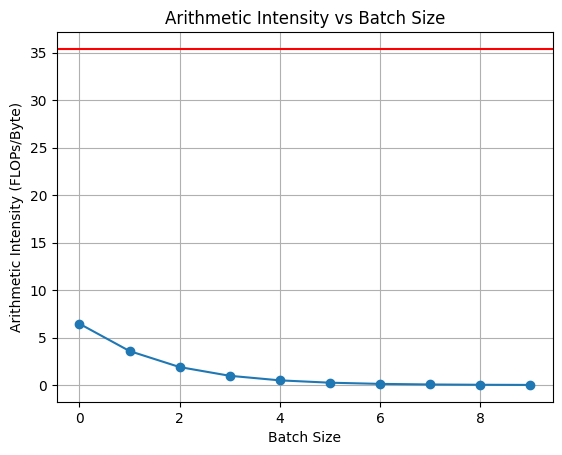

In [14]:
import matplotlib.pyplot as plt
batch_sizes = [ 2 ** i for i in range(0, 10) ]

arithmetic_intensities = []
thresholds = []

for batch_size in batch_sizes:
    inputs = torch.randn(batch_size, 64).to(device)
    _flops_prelu = flops_prelu(inputs)
    flops_linear = 64 * 32 * 2 * batch_size
    n_flops = _flops_prelu + flops_linear

    mem_prelu = inputs.numel() * batch_size * 4  # 4 bytes per float32
    mem_linear = (inputs.numel() * batch_size + 32 * batch_size) * 4
    n_mem = mem_prelu + mem_linear

    arithmetic_intensity = n_flops / n_mem
    arithmetic_intensities.append(arithmetic_intensity)
    thresholds.append(threshold)

plt.plot(arithmetic_intensities, marker='o')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.xlabel('Batch Size')
plt.ylabel('Arithmetic Intensity (FLOPs/Byte)')
plt.title('Arithmetic Intensity vs Batch Size')
plt.grid(True)
plt.show()

What is the optimal batch size for your gpu? [1 point]

YOUR ANSWER HERE

#### Bonus (not mandatory) [2 points]

Answer all questions in task 5 again, but considering that the PReLU and the Linear are fused.

### Task 6 - Memory

Consider this vision model. We will try to estimate its memory usage.

How many parameters does it have? How much memory do the parameters take up? [2 points]

In [15]:
import timm

model = timm.create_model("convnextv2_large").to(device)

In [16]:
n_params = sum(p.numel() for p in model.parameters())
n_memory = n_params * 4  # assuming float32, which is 4 bytes per parameter

print(f"Number of parameters: {n_params}")
print(f"Memory required for parameters: {n_memory / (1024 ** 2):.2f} MB")

Number of parameters: 197956840
Memory required for parameters: 755.15 MB


In [17]:
assert n_params > 0
assert n_memory > 0

Profile the forward pass. What is the maximum of memory used? Deduce the memory size of activations. [2 points]

*In notebooks, variables are kept in memory between 2 cells execution. Be careful about that when executing a cell twice!*

In [18]:
batch_size = 8
x = torch.randn(batch_size, 3, 224, 224, device = device)

with torch.no_grad():
    torch.cuda.reset_peak_memory_stats(device)
    model(x)
    max_memory_used = torch.cuda.max_memory_allocated(device)

print(f"Maximum memory used during forward pass: {max_memory_used / (1024 ** 2):.2f} MB")

# Deduce the memory size of activations
memory_params = n_params * 4  # assuming float32, which is 4 bytes per parameter
memory_activations = max_memory_used - memory_params

print(f"Memory size of activations: {memory_activations / (1024 ** 2):.2f} MB")

Maximum memory used during forward pass: 1046.04 MB
Memory size of activations: 290.90 MB


Say you want to train this model using the Adam optimizer.
- How much memory will be used at maximum with batch size 1? [1 point]
- What is the maximum batch size that will fit on your gpu? [1 point]
- Try to run a training iteration. Is the actual memory usage close to your estimations? [1 point]

YOUR ANSWER HERE

In [19]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 